# Intro to Machine Learning with Snowpark ML

Source: https://quickstarts.snowflake.com/guide/intro_to_machine_learning_with_snowpark_ml_for_python/#0

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.types import StructType, StructField, DoubleType, DecimalType
import snowflake.snowpark.functions as F

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import Registry
from snowflake.ml._internal.utils import identifier
from snowflake.snowpark.functions import udf

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# Misc
import json
import joblib
import cachetools

# warning suppresion
import warnings; warnings.simplefilter('ignore')

### Establish Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [2]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open("connection.json"))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql(
    "SELECT current_user(), current_version()"
).collect()
snowpark_version = VERSION

# Current Environment Details
print("\nConnection Established with the following parameters:")
print("User                        : {}".format(snowflake_environment[0][0]))
print("Role                        : {}".format(session.get_current_role()))
print("Database                    : {}".format(session.get_current_database()))
print("Schema                      : {}".format(session.get_current_schema()))
print("Warehouse                   : {}".format(session.get_current_warehouse()))
print("Snowflake version           : {}".format(snowflake_environment[0][1]))
print(
    "Snowpark for Python version : {}.{}.{}".format(
        snowpark_version[0], snowpark_version[1], snowpark_version[2]
    )
)


Connection Established with the following parameters:
User                        : MLDEMO
Role                        : "ACCOUNTADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 8.18.0
Snowpark for Python version : 1.14.0


## 1. Data Ingestion

We will use The `diamonds` dataset to demonstrate Snowflake's native data science transformers in terms of database functionality and Spark & Pandas comportablity, using non-synthetic data. The `diamonds.csv` was previously staged using the accompanying `setup.sql` statement. 

This file can also be found here: https://sfquickstarts.s3.us-west-1.amazonaws.com/intro-to-machine-learning-with-snowpark-ml-for-python/diamonds.csv

In [3]:
# Show the file before loading
session.sql("LS @DIAMONDS_ASSETS;").show()

# Create a Snowpark DataFrame that is configured to load data from the CSV file
# We can now infer schema from CSV files.
diamonds_df = session.read.options(
    {
        "field_delimiter": ",",
        "field_optionally_enclosed_by": '"',
        "infer_schema": True,
        "parse_header": True,
    }
).csv("@DIAMONDS_ASSETS")

diamonds_df.show()

------------------------------------------------------------------------------------------------------------
|"name"                        |"size"   |"md5"                             |"last_modified"               |
------------------------------------------------------------------------------------------------------------
|diamonds_assets/diamonds.csv  |2772144  |4949e1d980ba4d2abb325011c42f2778  |Mon, 6 May 2024 23:36:17 GMT  |
------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------
|"carat"  |"cut"      |"color"  |"clarity"  |"depth"  |"table"  |"price"  |"x"   |"y"   |"z"   |
------------------------------------------------------------------------------------------------
|0.23     |Ideal      |E        |SI2        |61.5     |55.0     |326      |3.95  |3.98  |2.43  |
|0.21     |Premium    |E        |SI1        |59.8     |61.0     |3

### 1.1 - clean data
Update headers to uppercase using Snowpark DataFrame operations for standardization.

In [4]:
# Update headers to uppercase
for colname in diamonds_df.columns:
    if colname == '"table"':
        new_colname = "TABLE_PCT"
    else:
        new_colname = str.upper(colname)
    diamonds_df = diamonds_df.with_column_renamed(colname, new_colname)

diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"CUT"      |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |
----------------------------------------------------------------------------------------------------
|0.23     |Ideal      |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |
|0.21     |Premium    |E        |SI1        |59.8     |61.0         |326      |3.89  |3.84  |2.31  |
|0.23     |Good       |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |
|0.29     |Premium    |I        |VS2        |62.4     |58.0         |334      |4.20  |4.23  |2.63  |
|0.31     |Good       |J        |SI2        |63.3     |58.0         |335      |4.34  |4.35  |2.75  |
|0.24     |Very Good  |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |
|0.24     |Very Good  |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98 

Next, we standardize the category formatting for `CUT` using Snowpark DataFrame operations.

This way, when we write to a Snowflake table, there will be no inconsistencies in how the Snowpark DataFrame will read in the category names. Secondly, the feature transformations on categoricals will be easier to encode.

In [5]:
def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), "[^a-zA-Z0-9]+", "_"))


for col in ["CUT"]:
    diamonds_df = diamonds_df.with_column(col, fix_values(col))

diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |
|0.21     |E        |SI1        |59.8     |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |
|0.23     |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |
|0.29     |I        |VS2        |62.4     |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |
|0.31     |J        |SI2        |63.3     |58.0         |335      |4.34  |4.35  |2.75  |GOOD       |
|0.24     |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |
|0.24     |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98  |2.47  |VER

Finally, let's cast the decimal types to DoubleType() since DecimalType() isn't support by Snowpark ML at the moment.

In [6]:
# check schema
for x in list(diamonds_df.schema):
    print(x)

for colname in ["CARAT", "X", "Y", "Z", "DEPTH", "TABLE_PCT"]:
    diamonds_df = diamonds_df.with_column(
        colname, diamonds_df[colname].cast(DoubleType())
    )

diamonds_df.show()

StructField('CARAT', DecimalType(3, 2), nullable=True)
StructField('COLOR', StringType(16777216), nullable=True)
StructField('CLARITY', StringType(16777216), nullable=True)
StructField('DEPTH', DecimalType(3, 1), nullable=True)
StructField('TABLE_PCT', DecimalType(3, 1), nullable=True)
StructField('PRICE', LongType(), nullable=True)
StructField('X', DecimalType(4, 2), nullable=True)
StructField('Y', DecimalType(4, 2), nullable=True)
StructField('Z', DecimalType(4, 2), nullable=True)
StructField('CUT', StringType(16777216), nullable=True)
----------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |
----------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |
|E        |SI1        |326      |PREMIUM    |0.21   

### 1.2 - Write cleaned data to a Snowflake table

In [7]:

diamonds_df.write.mode('overwrite').save_as_table('diamonds')

## 2. ML Feature Transformations

- We will walk through a few transformations that are included in the Snowpark ML Preprocessing API. 
    https://docs.snowflake.com/en/developer-guide/snowpark-ml/reference/latest/index
    
- We will also build a preprocessing pipeline to be used in the ML modeling notebook.

***Note: All feature transformations using Snowpark ML are distributed operations in the same way that Snowpark DataFrame operations are.***

In [8]:
# Specify the table name where we stored the diamonds dataset
DEMO_TABLE = 'diamonds'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

# First, we read in the data from a Snowflake table into a Snowpark DataFrame
diamonds_df = session.table(input_tbl)

### 2.1 - Feature Transformations

Let's use the `MinMaxScaler` to normalize the `CARAT` column.

In [9]:
# Normalize the CARAT column
snowml_mms = snowml.MinMaxScaler(input_cols=["CARAT"], output_cols=["CARAT_NORM"])
normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Reduce the number of decimals
new_col = normalized_diamonds_df.col("CARAT_NORM").cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column("CARAT_NORM", new_col)

normalized_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
-------------------------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |0.006237      |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |0.002079      |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |0.006237      |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |0.018711      |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |0.022869      |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.4

Let's use the `OrdinalEncoder` to transform `COLOR` and `CLARITY` from categorical to numerical values so they are more meaningful.

In [10]:
# Encode CUT and CLARITY preserve ordinal importance
categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(
        ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]
    ),
}
snowml_oe = snowml.OrdinalEncoder(
    input_cols=["CUT", "CLARITY"],
    output_cols=["CUT_OE", "CLARITY_OE"],
    categories=categories,
)
ord_encoded_diamonds_df = snowml_oe.fit(normalized_diamonds_df).transform(
    normalized_diamonds_df
)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_diamonds_df.show()

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9
---------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|0.0       |6.

Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.

This is more for illustration purposes. Using the OrdinalEncoder makes more sense for the diamonds dataset since `CARAT`, `COLOR`, and `CLARITY` all follow a natural ranking order.

In [11]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["CUT", "COLOR", "CLARITY"], output_cols=["CUT_OHE", "COLOR_OHE", "CLARITY_OHE"])
transformed_diamonds_df = snowml_ohe.fit(ord_encoded_diamonds_df).transform(ord_encoded_diamonds_df)

np.array(transformed_diamonds_df.columns)

array(['CUT_OHE_FAIR', 'CUT_OHE_GOOD', 'CUT_OHE_IDEAL', 'CUT_OHE_PREMIUM',
       'CUT_OHE_VERY_GOOD', 'COLOR_OHE_D', 'COLOR_OHE_E', 'COLOR_OHE_F',
       'COLOR_OHE_G', 'COLOR_OHE_H', 'COLOR_OHE_I', 'COLOR_OHE_J',
       'CLARITY_OHE_I1', 'CLARITY_OHE_IF', 'CLARITY_OHE_SI1',
       'CLARITY_OHE_SI2', 'CLARITY_OHE_VS1', 'CLARITY_OHE_VS2',
       'CLARITY_OHE_VVS1', 'CLARITY_OHE_VVS2', 'CUT_OE', 'CLARITY_OE',
       'COLOR', 'CLARITY', 'PRICE', 'CUT', 'CARAT', 'X', 'Y', 'Z',
       'DEPTH', 'TABLE_PCT', 'CARAT_NORM'], dtype='<U17')

### 2.2 - Build a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standarized feature transformations.

In [12]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

Build `Pipeline`

In [13]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
        (
            "OE",
            snowml.OrdinalEncoder(
                input_cols=CATEGORICAL_COLUMNS,
                output_cols=CATEGORICAL_COLUMNS_OE,
                categories=categories,
            ),
        ),
        (
            "MMS",
            snowml.MinMaxScaler(
                clip=True,
                input_cols=NUMERICAL_COLUMNS,
                output_cols=NUMERICAL_COLUMNS,
            ),
        ),
    ]
)

PIPELINE_FILE = "preprocessing_pipeline.joblib"
joblib.dump(
    preprocessing_pipeline, PIPELINE_FILE
)  # We are just pickling it locally first

transformed_diamonds_df = preprocessing_pipeline.fit(diamonds_df).transform(diamonds_df)
transformed_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326      |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

Save the pickled object into the deployment stage

In [14]:
session.file.put(PIPELINE_FILE, "@ML_HOL_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2068, target_size=1120, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### 2.3 - Data Exploration

Now that we've transformed our features, let's calculate the correlation using Snowpark ML's `correlation()` function between each pair to better understand their relationships.

*Note: Snowpark ML's pearson correlation function returns a Pandas DataFrame*

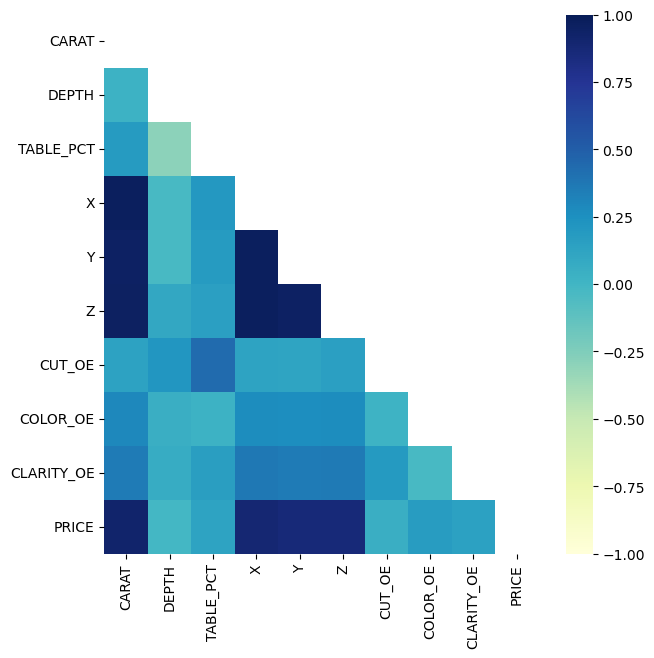

In [15]:
corr_diamonds_df = correlation(df=transformed_diamonds_df)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_diamonds_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_diamonds_df, mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

We note that `CARAT` and `PRICE` are highly correlated, which makes sense! Let's take a look at their relationship a bit closer.

*Note: You will have to convert your Snowpark DF to a Pandas DF in order to use matplotlib & seaborn.*

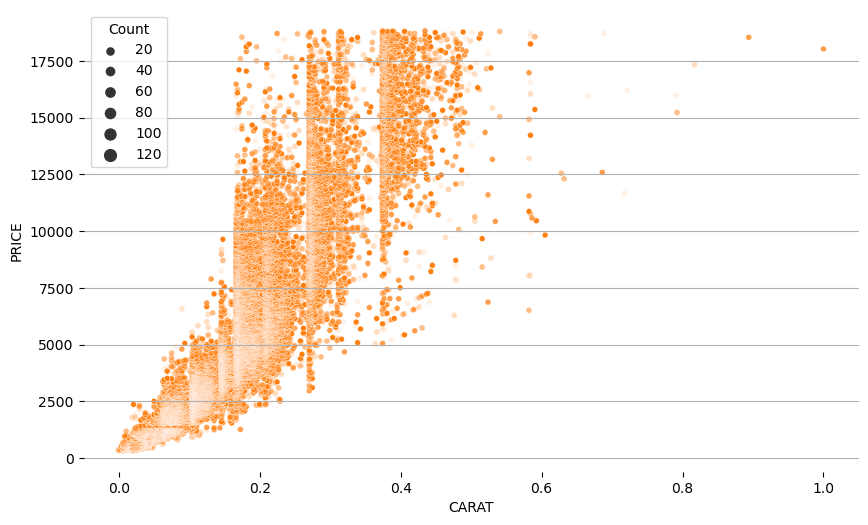

In [16]:
# Set up a plot to look at CARAT and PRICE
counts = transformed_diamonds_df.to_pandas().groupby(['PRICE', 'CARAT']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(data=counts, x='CARAT', y='PRICE', size='Count', markers='o', alpha=(0.1, .25, 0.5, 0.75, 1))
ax.grid(axis='y')

# The relationship is not linear - it appears exponential which makes sense given the rarity of the large diamonds
sns.move_legend(ax, "upper left")
sns.despine(left=True, bottom=True)

## 3. ML Modeling

- we will illustrate how to train an `XGBoost` model with the diamonds dataset using the Snowpark ML Model API. 
- We also show how to do inference and manage models via Model Registry or as a UDF (See Appendix).

### 3.1 - Build a simple XGBoost Regression model

What's happening here? 

- The `model.fit()` function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a [Snowpark Optimized Warehouse](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized) if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
- The `model.predict()` function actually creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.

You can check the query history once you execute the following cell to check.

In [17]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']

In [18]:
# Split the data into train and test sets
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(weights=[0.9, 0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(diamonds_train_df).transform(diamonds_train_df)
test_df = preprocessing_pipeline.transform(diamonds_test_df)

In [19]:
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)

In [20]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].to_pandas())

,CUT_OE,COLOR_OE,CLARITY_OE,CARAT,DEPTH,TABLE_PCT,X,Y,Z,PREDICTED_PRICE
0,2.0,6.0,5.0,0.020790,0.547222,0.307692,0.391993,0.072496,0.083648,322.593506
1,2.0,6.0,5.0,0.022869,0.455556,0.365385,0.408752,0.075212,0.082390,267.302460
2,1.0,5.0,3.0,0.008316,0.541667,0.269231,0.369646,0.066893,0.077673,385.477814
3,2.0,0.0,4.0,0.006237,0.486111,0.346154,0.368715,0.067402,0.075472,434.468170
4,1.0,4.0,5.0,0.020790,0.552778,0.307692,0.398510,0.071986,0.084277,566.351562
...,...,...,...,...,...,...,...,...,...,...
5407,2.0,1.0,5.0,0.103950,0.505556,0.269231,0.528864,0.097284,0.109748,2636.223389
5408,1.0,5.0,3.0,0.116424,0.452778,0.365385,0.552142,0.099321,0.109748,2343.046143
5409,2.0,1.0,4.0,0.103950,0.550000,0.326923,0.520484,0.095925,0.111006,2690.643066
5410,0.0,3.0,3.0,0.106029,0.511111,0.250000,0.536313,0.097284,0.111006,3194.863525


### 3.2 - Evaluate Predictions
Let's analyze the results using Snowpark ML's Mean Absolute Percentage Error (MAPE).

-------------------------------
|"PRICE"  |"PREDICTED_PRICE"  |
-------------------------------
|351      |322.593505859375   |
|353      |267.3024597167969  |
|355      |385.4778137207031  |
|357      |434.4681701660156  |
|554      |566.3515625        |
|554      |492.4712219238281  |
|2757     |2734.483642578125  |
|2759     |2950.267578125     |
|2759     |2802.850830078125  |
|2762     |2944.725341796875  |
-------------------------------

Mean absolute percentage error: 0.07117102331735714


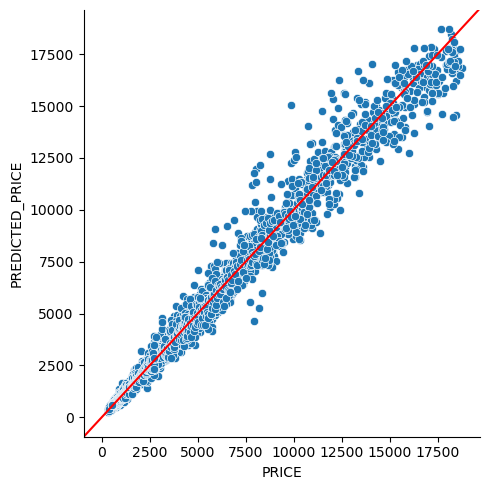

In [21]:
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="PRICE", 
                                        y_pred_col_names="PREDICTED_PRICE")

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### 3.3 - Model Tuning

Now, let's use Snowpark ML's **Distributed** `GridSearchCV()` function to find optimal model parameters

We will increase the warehouse size to scale up our hyperparameter tuning to take advantage of parallelized model training to accelerate this search. When done, we will scale down again.

In [22]:
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=LARGE;").collect()

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
grid_search.fit(train_df)

session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=XSMALL;").collect()

The version of package 'fastparquet' in the local environment is 2024.2.0, which does not fit the criteria for the requirement 'fastparquet<2023.11'. Your UDF might not work when the package version is different between the server and your local environment.


[Row(status='Statement executed successfully.')]

We see that the best estimator has the following parameters: `n_estimators=500` & `learning_rate=0.4`.

We can use `to_sklearn()` in order to get the actual xgboost model object, which gives us access to all its attributes.

In [23]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=3, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

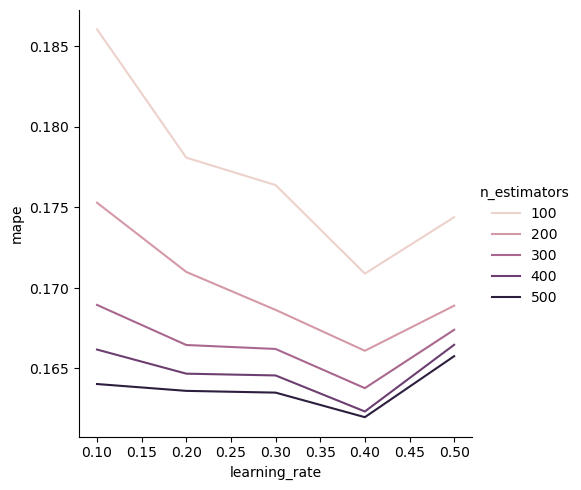

In [24]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

Now, let's predict and analyze the results from using the best estimator.

--------------------------------
|"PRICE"  |"PREDICTED_PRICE"   |
--------------------------------
|351      |353.2740173339844   |
|353      |343.84271240234375  |
|355      |431.1207275390625   |
|357      |355.054443359375    |
|554      |560.3695068359375   |
|554      |527.7815551757812   |
|2757     |2796.111083984375   |
|2759     |2878.782958984375   |
|2759     |3021.80224609375    |
|2762     |2838.24658203125    |
--------------------------------

Mean absolute percentage error: 0.06614988993792766


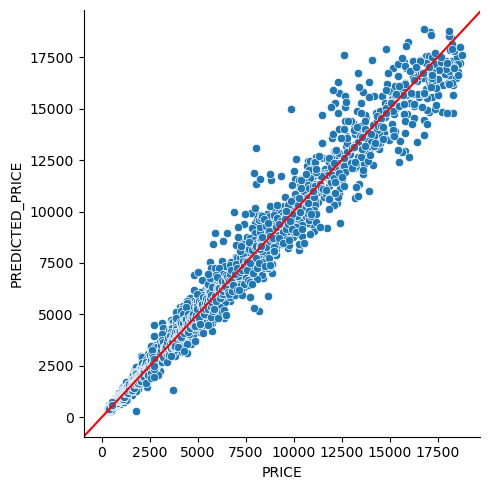

In [25]:
# Predict
result = grid_search.predict(test_df)

# Analyze results
mape = mean_absolute_percentage_error(
    df=result, y_true_col_names="PRICE", y_pred_col_names="PREDICTED_PRICE"
)

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### 3.4 - Save Optimized Model to Model Registry

Now, with Snowpark ML's model registry, we have a Snowflake native model versioning and deployment framework. This allows us to log models, tag parameters and metrics, track metadata, create versions, and ultimately execute batch inference tasks in a Snowflake warehouse or deploy to a Snowpark Container Service.

In [26]:
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

optimal_mape = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                                 (gs_results_df['learning_rate']==optimal_learning_rate), 'mape'].values[0]

In [27]:
# Get sample input data to pass into the registry logging function
X = train_df.select(CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS).limit(100)

db = identifier._get_unescaped_name(session.get_current_database())
schema = identifier._get_unescaped_name(session.get_current_schema())

# Define model name
model_name = "DIAMONDS_PRICE_PREDICTION"

# Create a registry and log the model
native_registry = Registry(session=session, database_name=db, schema_name=schema)

# Let's first log the very first model we trained
model_ver = native_registry.log_model(
    model_name=model_name,
    version_name='V0',
    model=regressor,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver.set_metric(metric_name="mean_abs_pct_err", value=mape)

# Add a description
model_ver.comment = "This is the first iteration of our Diamonds Price Prediction model. It is used for demo purposes."

# Now, let's log the optimal model from GridSearchCV
model_ver2 = native_registry.log_model(
    model_name=model_name,
    version_name='V1',
    model=optimal_model,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver2.set_metric(metric_name="mean_abs_pct_err", value=optimal_mape)

# Add a description
model_ver2.comment = "This is the second iteration of our Diamonds Price Prediction model \
                        where we performed hyperparameter optimization."

In [28]:
# Let's confirm they were added
native_registry.get_model(model_name).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-05-08 08:24:14.006000-07:00,V0,This is the first iteration of our Diamonds Pr...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,true,"[""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.06614988993...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
1,2024-05-08 08:24:54.169000-07:00,V1,This is the second iteration of our Diamonds P...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,false,"[""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.16197244497...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."


## 4. Model Inference

For the inference, we will look at 3 different ways:
- loading model from registry
- running a sql statement
- batch inference using a Vectorized UDF


### 4.1 - Fetch model from Registry and perform inference on test dataset

In [29]:
model_ver = native_registry.get_model(model_name).version('v1')
result_sdf2 = model_ver.run(test_df, function_name="predict")
result_sdf2.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"output_feature_0"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351      |VERY_GOOD  |353.2740173339844   |
|0.02286902286902287   |0.4555555555555555  

### 4.2 - Perform inference using SQL statement

In [30]:
# save test data as temp table
test_df.write.mode("overwrite").save_as_table("diamonds_test", table_type="temporary")

# for the default version:
session.sql(
    f"SELECT a.*, DIAMONDS_PRICE_PREDICTION!predict(a.CUT_OE, a.COLOR_OE, a.CLARITY_OE, a.CARAT, a.DEPTH, a.TABLE_PCT, a.X, a.Y, a.Z)['PREDICTED_PRICE'] as prediction from diamonds_test a"
).show()

# for any other version (for example V1 below):
session.sql(
    f"WITH model_version_alias AS MODEL {model_name} VERSION v1 SELECT a.*, model_version_alias!predict(a.CUT_OE, a.COLOR_OE, a.CLARITY_OE, a.CARAT, a.DEPTH, a.TABLE_PCT, a.X, a.Y, a.Z)['output_feature_0'] as prediction from diamonds_test a"
).show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"PREDICTION"           |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351      |VERY_GOOD  |3.225935058593750e+02  |
|0.02286902286902287   |0.455555

### 4.3 Batch inference using a Vectorized UDF


In case you have an existing model outside of our supported frameworks (scikit-learn, xgboost, lightgbm, pytorch, tensorflow, pyfunc), you can still execute batch inference via Vectorized UDFs.

Make sure to add your package to the `packages` section in the UDF registration call.

In [31]:
# Let's save our optimal model first
MODEL_FILE = 'model.joblib'
joblib.dump(optimal_model, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@ML_HOL_ASSETS", overwrite=True)

# Get all relevant column names to pass into the UDF call
feature_cols = test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].columns

In [32]:
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_diamond', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@ML_HOL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@ML_HOL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','xgboost'])
def batch_predict_diamond(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = ["CUT_OE", "COLOR_OE", "CLARITY_OE", 'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z']
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

Call Vectorized User-Defined Function (UDF) on test data.

In [33]:
test_df_w_preds = test_df.with_column('PREDICTED_PRICE', batch_predict_diamond(*feature_cols))
test_df_w_preds.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"PREDICTED_PRICE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351      |VERY_GOOD  |353.2740173339844   |
|0.02286902286902287   |0.4555555555555555  

Clean Up

In [34]:
# Clean up
native_registry.delete_model(model_name)
# Confirm it was deleted
native_registry.show_models()

session.close()

# Other resources

https://docs.snowflake.com/en/developer-guide/snowpark-ml/index?_fsi=LnQEPC1a&_fsi=LnQEPC1a


https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling


https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-mlops-model-registry

